In [1]:
from utils import PaintingsDataset
import random
from torchvision import transforms

# Building the dataset

image_dir = '../data/pixel_art/images/images/'

transform = transforms.Compose([
    transforms.ToTensor(), # Transforming to tensor
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5)) # Normalizing
])



images = PaintingsDataset(image_dir, transform)

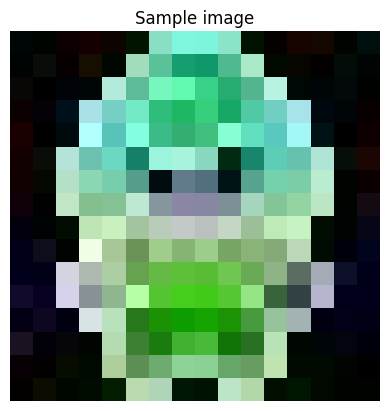

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Plotting an example from  the dataset
n = len(images)
integer = random.randint(0,n)
image = images[integer].numpy()*0.5 + 0.5

# Plot the image
plt.imshow(np.transpose(image, (1, 2, 0)))  
plt.axis('off')  # Hide axes
plt.title('Sample image')
plt.show()


In [3]:
from torch.utils.data import DataLoader

dataloader = DataLoader(images, batch_size=256)

In [4]:
from utils import Unet_Discriminator_V2, Unet_Generator_V2

latent_dim = 128
channels_out = 3
input_channels = 3
n_classes = 2

D_unet = Unet_Discriminator_V2(input_channels, n_classes)
G_unet = Unet_Generator_V2(latent_dim, channels_out)


In [5]:
noise_image = D_unet(images[0].unsqueeze(0))[1][0]

import torch

# Generate random noise
noise = torch.randn(1, latent_dim, 1, 1)  # Batch of 16 noise vectors

# Generate images
fake_images = G_unet(noise)

print(fake_images.size())  # Should be (16, img_channels, height, width)

torch.Size([1, 3, 16, 16])


In [6]:
from utils import (Unet_Discriminator, unet_d_criterion_without_cutmix_v2)
import torch
import torch.optim as optim
from tqdm.notebook import tqdm
import time

torch.autograd.set_detect_anomaly(True)

input_channels = 3
n_classes = 2
k = 1 # Steps to train generator
noise_dim = 128

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device) 

G_unet = G_unet.to(device)
D_unet = D_unet.to(device)

criterion = unet_d_criterion_without_cutmix_v2

optimizer_g_unet = optim.Adam(G_unet.parameters(), lr=1e-4, betas=(0.5, 0.999))
optimizer_d_unet = optim.Adam(D_unet.parameters(), lr=5e-4, betas=(0.5, 0.999)) 

D_loss, G_loss = [], []

epochs = 1000

for epoch in tqdm(range(epochs)):
    start_time = time.time()

    for batch in tqdm(dataloader):
        # Get real images
        real_images = batch.to(device)  # Move batch to GPU
        batch_size = real_images.size(0)
        labels_1 = torch.ones(batch_size, 1, device=device)  # Real labels on GPU
        labels_2 = torch.ones(batch_size, 1, device=device)

        # Train discriminator with real images
        D_unet.zero_grad()
        output = D_unet(real_images)
        loss_d_real = criterion(output, labels_1, batch_size)

        # Train discriminator with fake images
        noise = torch.randn(batch_size, noise_dim, 1, 1, device=device)  # Generate noise on GPU
        fake_images = G_unet(noise)
        labels_2.fill_(0)  # Fake labels
        output = D_unet(fake_images.detach())
        loss_d_fake = criterion(output, labels_2, batch_size)
        
        loss_d = loss_d_fake + loss_d_real
        loss_d.backward()
        optimizer_d_unet.step()

        if epoch % k == 0:
            # Train generator
            labels_3 = torch.ones(batch_size, 1, device=device)
            G_unet.zero_grad()
            labels_3.fill_(1)  # Real labels
            output = D_unet(fake_images)
            loss_g = criterion(output, labels_3, batch_size)
            loss_g.backward()
            optimizer_g_unet.step()
    

    D_loss.append(loss_d.item())
    G_loss.append(loss_g.item())
    
    end_time = time.time()
    if epoch % k == 0:

        print(f'Epoch [{epoch}/{epochs}] | Loss D: {loss_d.item()} | Loss G: {loss_g.item()}')
    else:
    
        print(f'Epoch [{epoch}/{epochs}] | Loss D: {loss_d.item()}')
    
    print(f'Epoch {epoch +1} duration :   {end_time - start_time}')

cuda


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [0/1000] | Loss D: 348.5836181640625 | Loss G: 176.48965454101562
Epoch 1 duration :   2.1520376205444336


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [1/1000] | Loss D: 286.29766845703125 | Loss G: 193.78372192382812
Epoch 2 duration :   1.4426062107086182


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [2/1000] | Loss D: 255.49691772460938 | Loss G: 311.4425048828125
Epoch 3 duration :   1.431089162826538


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [3/1000] | Loss D: 264.4120788574219 | Loss G: 240.39027404785156
Epoch 4 duration :   1.4305922985076904


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [4/1000] | Loss D: 235.17620849609375 | Loss G: 327.9859619140625
Epoch 5 duration :   1.4493634700775146


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [5/1000] | Loss D: 242.2154541015625 | Loss G: 279.91021728515625
Epoch 6 duration :   1.4587509632110596


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [6/1000] | Loss D: 204.7439727783203 | Loss G: 209.87741088867188
Epoch 7 duration :   1.462252140045166


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [7/1000] | Loss D: 151.69760131835938 | Loss G: 379.9732360839844
Epoch 8 duration :   1.51497220993042


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [8/1000] | Loss D: 199.86468505859375 | Loss G: 459.3620300292969
Epoch 9 duration :   1.4625496864318848


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [9/1000] | Loss D: 23.23660659790039 | Loss G: 1898.831298828125
Epoch 10 duration :   1.448613166809082


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [10/1000] | Loss D: 2883.71630859375 | Loss G: 545.85986328125
Epoch 11 duration :   1.489818811416626


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [11/1000] | Loss D: 203.4503173828125 | Loss G: 279.82623291015625
Epoch 12 duration :   1.448493242263794


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [12/1000] | Loss D: 163.86929321289062 | Loss G: 348.70941162109375
Epoch 13 duration :   1.6044487953186035


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [13/1000] | Loss D: 90.39718627929688 | Loss G: 421.6919860839844
Epoch 14 duration :   1.58418869972229


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [14/1000] | Loss D: 82.33047485351562 | Loss G: 633.2877807617188
Epoch 15 duration :   1.4797005653381348


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [15/1000] | Loss D: 214.52780151367188 | Loss G: 675.0853881835938
Epoch 16 duration :   1.5333073139190674


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [16/1000] | Loss D: 57.50537109375 | Loss G: 550.2424926757812
Epoch 17 duration :   1.5049686431884766


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [17/1000] | Loss D: 30.00303840637207 | Loss G: 962.1944580078125
Epoch 18 duration :   1.4324004650115967


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [18/1000] | Loss D: 823.6141357421875 | Loss G: 465.4416198730469
Epoch 19 duration :   1.4765303134918213


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [19/1000] | Loss D: 120.292724609375 | Loss G: 402.0428771972656
Epoch 20 duration :   1.473869800567627


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [20/1000] | Loss D: 64.37779998779297 | Loss G: 518.0010986328125
Epoch 21 duration :   1.4800825119018555


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [21/1000] | Loss D: 42.74827194213867 | Loss G: 630.2258911132812
Epoch 22 duration :   1.5021753311157227


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [22/1000] | Loss D: 35.050933837890625 | Loss G: 717.2915649414062
Epoch 23 duration :   1.5450406074523926


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [23/1000] | Loss D: 25.27051544189453 | Loss G: 810.6017456054688
Epoch 24 duration :   1.4478704929351807


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [24/1000] | Loss D: 16.975496292114258 | Loss G: 904.6370239257812
Epoch 25 duration :   1.7790210247039795


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [25/1000] | Loss D: 8.872598648071289 | Loss G: 3148.80029296875
Epoch 26 duration :   1.7362515926361084


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [26/1000] | Loss D: 384.70751953125 | Loss G: 74.36985778808594
Epoch 27 duration :   1.7832205295562744


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [27/1000] | Loss D: 360.4552917480469 | Loss G: 190.5747528076172
Epoch 28 duration :   1.8909680843353271


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [28/1000] | Loss D: 357.32275390625 | Loss G: 183.6776885986328
Epoch 29 duration :   2.133566379547119


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [29/1000] | Loss D: 356.8395080566406 | Loss G: 182.95782470703125
Epoch 30 duration :   1.8826067447662354


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [30/1000] | Loss D: 356.64996337890625 | Loss G: 182.8895263671875
Epoch 31 duration :   1.816831350326538


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [31/1000] | Loss D: 356.52728271484375 | Loss G: 182.78897094726562
Epoch 32 duration :   1.9727146625518799


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [32/1000] | Loss D: 356.3741455078125 | Loss G: 182.8192138671875
Epoch 33 duration :   1.9057636260986328


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [33/1000] | Loss D: 367.837646484375 | Loss G: 202.5214385986328
Epoch 34 duration :   1.816354751586914


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [34/1000] | Loss D: 356.6685791015625 | Loss G: 181.8363800048828
Epoch 35 duration :   1.856119155883789


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [35/1000] | Loss D: 5235.650390625 | Loss G: 190.91262817382812
Epoch 36 duration :   1.8339240550994873


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [36/1000] | Loss D: 358.2294616699219 | Loss G: 187.67709350585938
Epoch 37 duration :   1.7717218399047852


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [37/1000] | Loss D: 356.50274658203125 | Loss G: 180.27854919433594
Epoch 38 duration :   2.2348289489746094


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [38/1000] | Loss D: 356.14501953125 | Loss G: 175.44114685058594
Epoch 39 duration :   5.434706687927246


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [39/1000] | Loss D: 355.990966796875 | Loss G: 172.79270935058594
Epoch 40 duration :   5.89241886138916


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [40/1000] | Loss D: 355.8136291503906 | Loss G: 171.28443908691406
Epoch 41 duration :   5.927103281021118


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [41/1000] | Loss D: 355.5827331542969 | Loss G: 172.9944610595703
Epoch 42 duration :   5.6290366649627686


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [42/1000] | Loss D: 355.47930908203125 | Loss G: 170.69700622558594
Epoch 43 duration :   5.731232643127441


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [43/1000] | Loss D: 355.18133544921875 | Loss G: 175.89730834960938
Epoch 44 duration :   5.381963729858398


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [44/1000] | Loss D: 355.0831604003906 | Loss G: 171.9449462890625
Epoch 45 duration :   5.816354036331177


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [45/1000] | Loss D: 354.3675537109375 | Loss G: 178.3152313232422
Epoch 46 duration :   5.365514039993286


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [46/1000] | Loss D: 354.38592529296875 | Loss G: 174.29473876953125
Epoch 47 duration :   5.372490167617798


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [47/1000] | Loss D: 353.63232421875 | Loss G: 178.87171936035156
Epoch 48 duration :   5.1833577156066895


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [48/1000] | Loss D: 353.18475341796875 | Loss G: 179.38580322265625
Epoch 49 duration :   5.2585060596466064


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [49/1000] | Loss D: 352.12835693359375 | Loss G: 183.2525177001953
Epoch 50 duration :   5.51506233215332


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [50/1000] | Loss D: 350.5560302734375 | Loss G: 175.85536193847656
Epoch 51 duration :   5.7573418617248535


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [51/1000] | Loss D: 353.762939453125 | Loss G: 153.34324645996094
Epoch 52 duration :   6.470417737960815


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [52/1000] | Loss D: 348.32342529296875 | Loss G: 179.07986450195312
Epoch 53 duration :   6.533140182495117


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [53/1000] | Loss D: 345.5625915527344 | Loss G: 183.10211181640625
Epoch 54 duration :   6.872777462005615


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [54/1000] | Loss D: 342.9202880859375 | Loss G: 181.80445861816406
Epoch 55 duration :   5.642302513122559


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [55/1000] | Loss D: 343.0225830078125 | Loss G: 184.03237915039062
Epoch 56 duration :   5.373712062835693


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [56/1000] | Loss D: 340.5953063964844 | Loss G: 188.4772491455078
Epoch 57 duration :   6.817550182342529


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [57/1000] | Loss D: 328.40185546875 | Loss G: 213.3470001220703
Epoch 58 duration :   2.156022548675537


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [58/1000] | Loss D: 304.3162841796875 | Loss G: 225.2666778564453
Epoch 59 duration :   1.4928665161132812


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [59/1000] | Loss D: 314.15228271484375 | Loss G: 232.3954620361328
Epoch 60 duration :   1.4918112754821777


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [60/1000] | Loss D: 290.488525390625 | Loss G: 262.2298583984375
Epoch 61 duration :   1.4737157821655273


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [61/1000] | Loss D: 250.81036376953125 | Loss G: 316.7960205078125
Epoch 62 duration :   1.494936466217041


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [62/1000] | Loss D: 268.0546569824219 | Loss G: 472.8726501464844
Epoch 63 duration :   1.4912424087524414


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [63/1000] | Loss D: 224.224365234375 | Loss G: 330.4583740234375
Epoch 64 duration :   1.466064691543579


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [64/1000] | Loss D: 196.88137817382812 | Loss G: 273.2820129394531
Epoch 65 duration :   1.4734718799591064


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [65/1000] | Loss D: 222.37686157226562 | Loss G: 322.8589172363281
Epoch 66 duration :   1.4790637493133545


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [66/1000] | Loss D: 180.64089965820312 | Loss G: 451.1957092285156
Epoch 67 duration :   1.5662658214569092


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [67/1000] | Loss D: 321.5277404785156 | Loss G: 542.865966796875
Epoch 68 duration :   1.6107048988342285


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [68/1000] | Loss D: 194.5224609375 | Loss G: 404.5579528808594
Epoch 69 duration :   1.550130844116211


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [69/1000] | Loss D: 148.2132568359375 | Loss G: 316.4727783203125
Epoch 70 duration :   1.540095329284668


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [70/1000] | Loss D: 241.11463928222656 | Loss G: 521.7734985351562
Epoch 71 duration :   1.4955315589904785


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [71/1000] | Loss D: 130.03469848632812 | Loss G: 524.3472900390625
Epoch 72 duration :   1.5180563926696777


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [72/1000] | Loss D: 73.32093811035156 | Loss G: 782.7792358398438
Epoch 73 duration :   1.5391952991485596


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [73/1000] | Loss D: 1379.83837890625 | Loss G: 738.3956298828125
Epoch 74 duration :   1.4926679134368896


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [74/1000] | Loss D: 171.50233459472656 | Loss G: 432.8087463378906
Epoch 75 duration :   1.474104404449463


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [75/1000] | Loss D: 99.71080780029297 | Loss G: 575.6336059570312
Epoch 76 duration :   1.4700555801391602


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [76/1000] | Loss D: 59.379478454589844 | Loss G: 884.7101440429688
Epoch 77 duration :   1.4915781021118164


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [77/1000] | Loss D: 15.369277000427246 | Loss G: 1163.2967529296875
Epoch 78 duration :   1.4733188152313232


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [78/1000] | Loss D: 6.7807841300964355 | Loss G: 1509.3177490234375
Epoch 79 duration :   1.5680193901062012


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [79/1000] | Loss D: 4.543087959289551 | Loss G: 2388.24853515625
Epoch 80 duration :   1.4889984130859375


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [80/1000] | Loss D: 3320.37744140625 | Loss G: 0.0
Epoch 81 duration :   1.4783058166503906


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [81/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 82 duration :   1.5011718273162842


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [82/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 83 duration :   1.4753220081329346


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [83/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 84 duration :   1.4686038494110107


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [84/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 85 duration :   1.5480172634124756


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [85/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 86 duration :   1.4722838401794434


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [86/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 87 duration :   1.4746687412261963


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [87/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 88 duration :   1.4819188117980957


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [88/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 89 duration :   1.4769093990325928


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [89/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 90 duration :   1.4710569381713867


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [90/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 91 duration :   1.5120363235473633


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [91/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 92 duration :   1.4882051944732666


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [92/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 93 duration :   1.4801356792449951


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [93/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 94 duration :   1.4758267402648926


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [94/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 95 duration :   1.4819958209991455


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [95/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 96 duration :   1.47145676612854


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [96/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 97 duration :   1.5380756855010986


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [97/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 98 duration :   1.4628417491912842


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [98/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 99 duration :   1.4770796298980713


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [99/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 100 duration :   1.4759883880615234


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [100/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 101 duration :   1.4583492279052734


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [101/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 102 duration :   1.4832029342651367


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [102/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 103 duration :   1.5364410877227783


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [103/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 104 duration :   1.4935288429260254


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [104/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 105 duration :   1.4818425178527832


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [105/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 106 duration :   1.4714548587799072


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [106/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 107 duration :   1.470156192779541


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [107/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 108 duration :   1.5121760368347168


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [108/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 109 duration :   1.5329623222351074


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [109/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 110 duration :   1.5314486026763916


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [110/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 111 duration :   1.505859375


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [111/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 112 duration :   1.5061376094818115


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [112/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 113 duration :   1.5154619216918945


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [113/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 114 duration :   1.5384421348571777


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [114/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 115 duration :   1.5084092617034912


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [115/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 116 duration :   1.5706217288970947


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [116/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 117 duration :   1.5458920001983643


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [117/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 118 duration :   1.5634596347808838


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [118/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 119 duration :   1.5420546531677246


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [119/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 120 duration :   1.641324520111084


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [120/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 121 duration :   1.5517208576202393


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [121/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 122 duration :   1.6154084205627441


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [122/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 123 duration :   1.5344340801239014


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [123/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 124 duration :   1.5772006511688232


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [124/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 125 duration :   1.6655869483947754


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [125/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 126 duration :   1.647407054901123


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [126/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 127 duration :   1.590188980102539


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [127/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 128 duration :   1.6128013134002686


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [128/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 129 duration :   1.7298953533172607


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [129/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 130 duration :   1.588228464126587


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [130/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 131 duration :   1.6442317962646484


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [131/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 132 duration :   1.6357762813568115


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [132/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 133 duration :   1.6185519695281982


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [133/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 134 duration :   1.64668607711792


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [134/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 135 duration :   1.6406843662261963


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [135/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 136 duration :   1.675593614578247


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [136/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 137 duration :   1.555525302886963


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [137/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 138 duration :   1.5697133541107178


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [138/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 139 duration :   1.582526445388794


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [139/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 140 duration :   1.6323230266571045


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [140/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 141 duration :   1.6112346649169922


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [141/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 142 duration :   1.670032262802124


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [142/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 143 duration :   1.6242377758026123


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [143/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 144 duration :   1.6105256080627441


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [144/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 145 duration :   1.634279727935791


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [145/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 146 duration :   1.6393656730651855


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [146/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 147 duration :   1.658823013305664


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [147/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 148 duration :   1.6071116924285889


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [148/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 149 duration :   1.6176774501800537


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [149/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 150 duration :   1.6124367713928223


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [150/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 151 duration :   1.6269595623016357


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [151/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 152 duration :   1.660888433456421


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [152/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 153 duration :   1.699960708618164


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [153/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 154 duration :   1.621924638748169


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [154/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 155 duration :   1.6777417659759521


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [155/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 156 duration :   1.5974349975585938


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [156/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 157 duration :   1.7469065189361572


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [157/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 158 duration :   1.6482129096984863


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [158/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 159 duration :   1.6389164924621582


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [159/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 160 duration :   1.6361899375915527


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [160/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 161 duration :   1.7810711860656738


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [161/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 162 duration :   1.646927833557129


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [162/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 163 duration :   1.724890947341919


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [163/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 164 duration :   1.7185449600219727


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [164/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 165 duration :   1.670976161956787


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [165/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 166 duration :   1.643017292022705


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [166/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 167 duration :   1.6518807411193848


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [167/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 168 duration :   1.7654385566711426


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [168/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 169 duration :   1.7029433250427246


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [169/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 170 duration :   1.6699340343475342


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [170/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 171 duration :   1.7046527862548828


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [171/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 172 duration :   1.6926288604736328


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [172/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 173 duration :   1.6839425563812256


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [173/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 174 duration :   1.7002201080322266


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [174/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 175 duration :   1.6942119598388672


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [175/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 176 duration :   1.6558005809783936


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [176/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 177 duration :   1.671614646911621


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [177/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 178 duration :   1.6805932521820068


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [178/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 179 duration :   1.6635386943817139


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [179/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 180 duration :   1.7265174388885498


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [180/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 181 duration :   1.7064831256866455


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [181/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 182 duration :   1.7398681640625


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [182/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 183 duration :   1.7099602222442627


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [183/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 184 duration :   1.6693997383117676


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [184/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 185 duration :   1.796778678894043


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [185/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 186 duration :   1.7163898944854736


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [186/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 187 duration :   1.7130935192108154


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [187/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 188 duration :   1.755476951599121


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [188/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 189 duration :   1.7701375484466553


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [189/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 190 duration :   1.7161056995391846


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [190/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 191 duration :   1.7947509288787842


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [191/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 192 duration :   1.657862663269043


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [192/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 193 duration :   1.6569888591766357


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [193/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 194 duration :   1.7933902740478516


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [194/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 195 duration :   1.6729567050933838


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [195/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 196 duration :   1.7944440841674805


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [196/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 197 duration :   1.7067255973815918


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [197/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 198 duration :   1.7570562362670898


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [198/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 199 duration :   1.7902193069458008


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [199/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 200 duration :   1.7842097282409668


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [200/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 201 duration :   1.8431570529937744


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [201/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 202 duration :   1.676835060119629


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [202/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 203 duration :   1.6858878135681152


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [203/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 204 duration :   1.6905860900878906


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [204/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 205 duration :   1.7371528148651123


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [205/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 206 duration :   1.84358811378479


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [206/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 207 duration :   1.6774935722351074


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [207/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 208 duration :   1.720151424407959


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [208/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 209 duration :   1.731630563735962


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [209/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 210 duration :   1.709587574005127


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [210/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 211 duration :   1.751343011856079


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [211/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 212 duration :   1.7326736450195312


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [212/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 213 duration :   1.7169034481048584


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [213/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 214 duration :   1.720555305480957


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [214/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 215 duration :   1.7170920372009277


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [215/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 216 duration :   1.7652993202209473


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [216/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 217 duration :   1.743452787399292


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [217/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 218 duration :   1.7461674213409424


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [218/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 219 duration :   1.7449889183044434


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [219/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 220 duration :   1.768791675567627


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [220/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 221 duration :   1.7347924709320068


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [221/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 222 duration :   1.7371652126312256


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [222/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 223 duration :   1.752732276916504


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [223/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 224 duration :   1.7403130531311035


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [224/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 225 duration :   1.725327968597412


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [225/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 226 duration :   1.7400996685028076


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [226/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 227 duration :   1.7157564163208008


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [227/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 228 duration :   1.7180092334747314


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [228/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 229 duration :   1.7366671562194824


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [229/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 230 duration :   1.7406442165374756


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [230/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 231 duration :   1.8102333545684814


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [231/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 232 duration :   1.8056092262268066


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [232/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 233 duration :   1.7911083698272705


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [233/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 234 duration :   1.8131225109100342


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [234/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 235 duration :   1.8447792530059814


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [235/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 236 duration :   1.7254395484924316


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [236/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 237 duration :   1.8194420337677002


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [237/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 238 duration :   1.7459654808044434


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [238/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 239 duration :   1.7462687492370605


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [239/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 240 duration :   1.7445087432861328


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [240/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 241 duration :   1.7600791454315186


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [241/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 242 duration :   1.7345211505889893


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [242/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 243 duration :   1.769540548324585


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [243/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 244 duration :   1.753206491470337


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [244/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 245 duration :   1.743013620376587


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [245/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 246 duration :   1.7878358364105225


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [246/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 247 duration :   1.747434139251709


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [247/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 248 duration :   1.759004831314087


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [248/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 249 duration :   1.7613537311553955


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [249/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 250 duration :   1.7502572536468506


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [250/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 251 duration :   1.7786226272583008


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [251/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 252 duration :   1.7696716785430908


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [252/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 253 duration :   1.7524371147155762


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [253/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 254 duration :   1.779639720916748


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [254/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 255 duration :   1.7471873760223389


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [255/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 256 duration :   1.8780598640441895


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [256/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 257 duration :   1.90903902053833


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [257/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 258 duration :   1.9290697574615479


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [258/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 259 duration :   1.9701924324035645


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [259/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 260 duration :   1.9742891788482666


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [260/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 261 duration :   1.962932825088501


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [261/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 262 duration :   1.9749391078948975


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [262/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 263 duration :   1.9420039653778076


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [263/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 264 duration :   2.0961551666259766


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [264/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 265 duration :   2.23368763923645


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [265/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 266 duration :   2.1911096572875977


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [266/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 267 duration :   1.9954922199249268


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [267/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 268 duration :   1.8841400146484375


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [268/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 269 duration :   1.9116907119750977


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [269/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 270 duration :   2.034998655319214


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [270/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 271 duration :   2.077458620071411


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [271/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 272 duration :   2.046668291091919


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [272/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 273 duration :   2.0156304836273193


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [273/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 274 duration :   2.0650088787078857


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [274/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 275 duration :   2.0692737102508545


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [275/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 276 duration :   2.2593698501586914


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [276/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 277 duration :   2.3954787254333496


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [277/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 278 duration :   2.339014768600464


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [278/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 279 duration :   2.3394813537597656


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [279/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 280 duration :   2.165363073348999


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [280/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 281 duration :   2.1275253295898438


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [281/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 282 duration :   2.216115951538086


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [282/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 283 duration :   2.1874263286590576


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [283/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 284 duration :   2.32055926322937


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [284/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 285 duration :   2.178001642227173


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [285/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 286 duration :   2.037315607070923


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [286/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 287 duration :   2.030259847640991


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [287/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 288 duration :   2.1509108543395996


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [288/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 289 duration :   2.333204984664917


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [289/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 290 duration :   1.9317591190338135


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [290/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 291 duration :   2.150479316711426


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [291/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 292 duration :   1.9445877075195312


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [292/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 293 duration :   2.0628676414489746


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [293/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 294 duration :   1.8492794036865234


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [294/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 295 duration :   1.8537559509277344


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [295/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 296 duration :   1.8752977848052979


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [296/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 297 duration :   1.8392555713653564


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [297/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 298 duration :   1.8025493621826172


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [298/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 299 duration :   1.8268487453460693


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [299/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 300 duration :   1.823413372039795


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [300/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 301 duration :   1.8000032901763916


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [301/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 302 duration :   1.8320858478546143


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [302/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 303 duration :   1.8091087341308594


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [303/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 304 duration :   1.8696620464324951


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [304/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 305 duration :   1.8246383666992188


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [305/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 306 duration :   1.8319237232208252


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [306/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 307 duration :   1.8312671184539795


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [307/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 308 duration :   1.8292288780212402


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [308/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 309 duration :   1.8388679027557373


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [309/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 310 duration :   1.8661842346191406


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [310/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 311 duration :   1.9335074424743652


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [311/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 312 duration :   1.9331247806549072


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [312/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 313 duration :   1.9028797149658203


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [313/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 314 duration :   1.9486045837402344


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [314/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 315 duration :   1.9983725547790527


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [315/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 316 duration :   1.983888864517212


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [316/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 317 duration :   1.950425148010254


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [317/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 318 duration :   2.0498733520507812


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [318/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 319 duration :   2.0807149410247803


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [319/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 320 duration :   1.930248737335205


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [320/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 321 duration :   1.887704610824585


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [321/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 322 duration :   1.8786518573760986


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [322/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 323 duration :   1.9237091541290283


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [323/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 324 duration :   1.9426791667938232


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [324/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 325 duration :   1.93682861328125


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [325/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 326 duration :   1.932356357574463


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [326/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 327 duration :   1.950077772140503


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [327/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 328 duration :   1.91581130027771


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [328/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 329 duration :   1.934863567352295


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [329/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 330 duration :   1.8950116634368896


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [330/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 331 duration :   1.8936607837677002


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [331/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 332 duration :   1.880230188369751


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [332/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 333 duration :   1.874776840209961


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [333/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 334 duration :   1.9009881019592285


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [334/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 335 duration :   1.8994741439819336


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [335/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 336 duration :   1.9153969287872314


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [336/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 337 duration :   1.8592588901519775


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [337/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 338 duration :   1.8611671924591064


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [338/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 339 duration :   1.8947758674621582


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [339/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 340 duration :   1.6688165664672852


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [340/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 341 duration :   1.8916587829589844


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [341/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 342 duration :   1.9734840393066406


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [342/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 343 duration :   1.810849666595459


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [343/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 344 duration :   1.7717866897583008


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [344/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 345 duration :   1.782257318496704


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [345/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 346 duration :   1.7689235210418701


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [346/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 347 duration :   1.7822494506835938


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [347/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 348 duration :   1.7792253494262695


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [348/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 349 duration :   1.7737500667572021


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [349/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 350 duration :   1.8234963417053223


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [350/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 351 duration :   2.168644905090332


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [351/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 352 duration :   2.169466018676758


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [352/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 353 duration :   1.9423305988311768


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [353/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 354 duration :   1.9496524333953857


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [354/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 355 duration :   1.8493995666503906


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [355/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 356 duration :   1.870589017868042


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [356/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 357 duration :   1.992629051208496


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [357/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 358 duration :   1.988067865371704


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [358/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 359 duration :   2.1040732860565186


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [359/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 360 duration :   2.012108564376831


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [360/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 361 duration :   1.9755463600158691


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [361/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 362 duration :   1.9604485034942627


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [362/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 363 duration :   1.9740052223205566


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [363/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 364 duration :   1.9627814292907715


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [364/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 365 duration :   1.9500255584716797


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [365/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 366 duration :   2.025852680206299


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [366/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 367 duration :   1.948859453201294


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [367/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 368 duration :   1.8474950790405273


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [368/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 369 duration :   2.024533748626709


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [369/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 370 duration :   1.8760271072387695


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [370/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 371 duration :   1.8836188316345215


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [371/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 372 duration :   1.854111671447754


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [372/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 373 duration :   1.9372737407684326


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [373/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 374 duration :   1.944657564163208


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [374/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 375 duration :   1.8356235027313232


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [375/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 376 duration :   1.858480453491211


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [376/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 377 duration :   1.8359475135803223


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [377/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 378 duration :   1.8426244258880615


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [378/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 379 duration :   1.8203237056732178


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [379/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 380 duration :   1.813781976699829


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [380/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 381 duration :   1.7944538593292236


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [381/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 382 duration :   1.8107373714447021


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [382/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 383 duration :   1.8257455825805664


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [383/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 384 duration :   1.8431663513183594


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [384/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 385 duration :   1.8134260177612305


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [385/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 386 duration :   1.8209264278411865


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [386/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 387 duration :   1.80861234664917


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [387/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 388 duration :   1.8183104991912842


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [388/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 389 duration :   1.8428869247436523


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [389/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 390 duration :   1.8870387077331543


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [390/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 391 duration :   1.897684097290039


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [391/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 392 duration :   1.8368334770202637


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [392/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 393 duration :   1.852992296218872


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [393/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 394 duration :   1.841698408126831


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [394/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 395 duration :   1.8305368423461914


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [395/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 396 duration :   1.8946516513824463


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [396/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 397 duration :   1.9866034984588623


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [397/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 398 duration :   2.0359864234924316


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [398/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 399 duration :   1.9048869609832764


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [399/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 400 duration :   1.8599317073822021


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [400/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 401 duration :   1.8510546684265137


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [401/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 402 duration :   1.8696610927581787


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [402/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 403 duration :   1.8665566444396973


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [403/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 404 duration :   1.8728089332580566


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [404/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 405 duration :   1.874457597732544


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [405/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 406 duration :   1.8800890445709229


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [406/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 407 duration :   1.950744390487671


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [407/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 408 duration :   1.8951363563537598


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [408/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 409 duration :   1.8788368701934814


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [409/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 410 duration :   1.889899492263794


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [410/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 411 duration :   1.8581666946411133


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [411/1000] | Loss D: 25700.0 | Loss G: 0.0
Epoch 412 duration :   1.8824291229248047


  0%|          | 0/4 [00:00<?, ?it/s]

KeyboardInterrupt: 

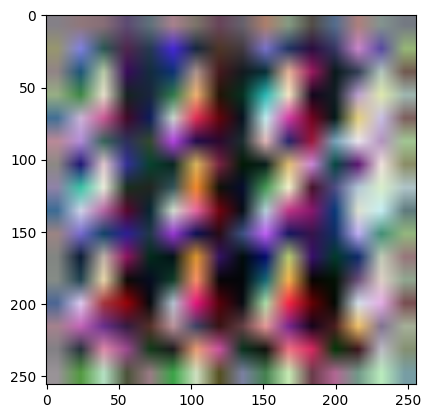

In [48]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

# Generate random noise
noise = torch.randn(1, latent_dim, 1, 1)  # Batch of 1 noise vector

G_unet_test = G_unet.to('cpu')
# Generate images
fake_images = G_unet_test(noise)

# Resize the generated image
resize_transform = transforms.Resize((256, 256))
resized_fake_images = resize_transform(fake_images)

# Convert to numpy array for visualization
image_noise = resized_fake_images.detach().numpy().reshape((3, 256, 256)) * 0.5 + 0.5

# Display the image
plt.imshow(np.transpose(image_noise, (1, 2, 0)))
plt.show()


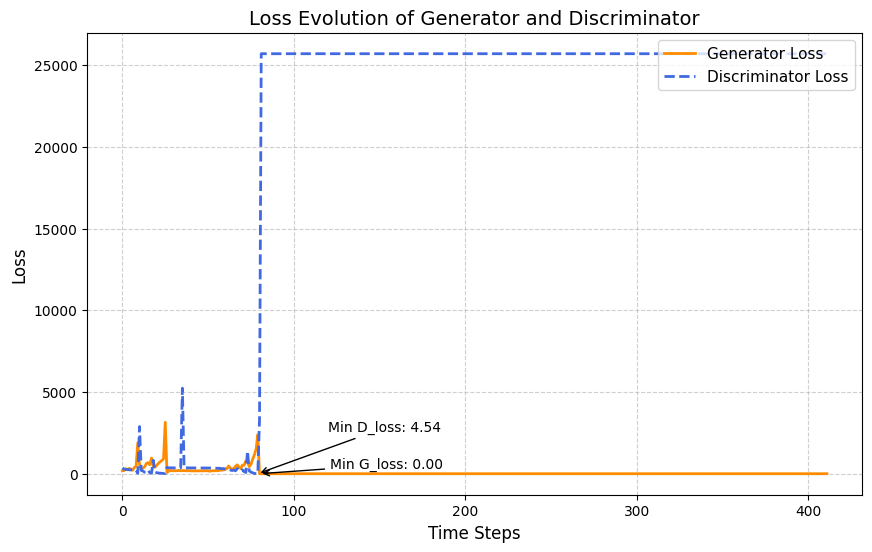

In [15]:
# Assuming G_loss and D_loss are defined
n = len(G_loss)
time_steps = [i for i in range(n)]

plt.figure(figsize=(10, 6))

# Plot Generator Loss
plt.plot(time_steps, G_loss, label='Generator Loss', color='darkorange', linestyle='-', linewidth=2)

# Plot Discriminator Loss
plt.plot(time_steps, D_loss, label='Discriminator Loss', color='royalblue', linestyle='--', linewidth=2)

# Add grid, labels, and title
plt.grid(True, linestyle='--', alpha=0.6)
plt.xlabel('Time Steps', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Loss Evolution of Generator and Discriminator', fontsize=14)

# Adding legend
plt.legend(loc='upper right', fontsize=11)

# Adding annotations for minimum loss points (optional)
min_G_loss = min(G_loss)
min_G_loss_idx = G_loss.index(min_G_loss)
plt.annotate(f'Min G_loss: {min_G_loss:.2f}', xy=(min_G_loss_idx, min_G_loss),
             xytext=(min_G_loss_idx + n*0.1, min_G_loss + max(G_loss)*0.1),
             arrowprops=dict(facecolor='black', arrowstyle='->'),
             fontsize=10)

min_D_loss = min(D_loss)
min_D_loss_idx = D_loss.index(min_D_loss)
plt.annotate(f'Min D_loss: {min_D_loss:.2f}', xy=(min_D_loss_idx, min_D_loss),
             xytext=(min_D_loss_idx + n*0.1, min_D_loss + max(D_loss)*0.1),
             arrowprops=dict(facecolor='black', arrowstyle='->'),
             fontsize=10)

# Show plot
plt.show()
